In [1]:
!pip3 install torchvision

In [2]:
!pip3 install --upgrade pip

In [3]:
!pip3 install torch torchvision --upgrade


In [5]:
!pip3 install torch

In [2]:
!pip3 install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 5.9 MB/s eta 0:00:0000:0100:01


In [4]:
!pip3 install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 966.0 kB/s eta 0:00:0000:0100:01


In [1]:
import os
import glob
import random
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Configuration
DATASET_DIR = "/Users/sadik2/Downloads/archive (6)/hand_keypoint_dataset_26k/hand_keypoint_dataset_26k/images/train"
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-3
CHECKPOINT_DIR = "checkpoints"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def add_gaussian_noise(image, mean=0.0, std=25.0):
    noise = torch.randn(image.size()) * (std / 255.0)
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)

class DenoisingDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        clean = self.transform(img)
        noisy = add_gaussian_noise(clean)
        return noisy, clean

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(3, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        self.middle = conv_block(128, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)  # 128 from upsample + 128 from enc3

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)   # 64 from upsample + 64 from enc2

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = conv_block(64, 32)    # 32 from upsample + 32 from enc1

        self.out = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        m = self.middle(self.pool3(e3))

        d3 = self.dec3(torch.cat([self.up3(m), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out(d1)

"""class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels)
            )

        self.enc1 = CBR(3, 32)
        self.enc2 = CBR(32, 64)
        self.enc3 = CBR(64, 128)

        self.pool = nn.MaxPool2d(2)

        self.middle = CBR(128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = CBR(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = CBR(64, 32)
        self.out = nn.Conv2d(32, 3, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        m = self.middle(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(m), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        out = self.out(d2)

        return out"""

# Collect image paths
all_image_paths = [p for p in Path(DATASET_DIR).glob("*") if p.is_file() and p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
random.shuffle(all_image_paths)

# Take only 5000 for training and 2000 for testing
train_paths = all_image_paths[:5000]
test_paths = all_image_paths[5000:7000]

train_dataset = DenoisingDataset(train_paths)
test_dataset = DenoisingDataset(test_paths)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for noisy, clean in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/unet_epoch{epoch+1}.pth")
    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")

# Evaluation
latest_ckpt = sorted(Path(CHECKPOINT_DIR).glob("*.pth"))[-1]
model.load_state_dict(torch.load(latest_ckpt, map_location=device))
model.eval()

psnr_total = 0
ssim_total = 0

with torch.no_grad():
    for noisy, clean in tqdm(test_loader, desc="Evaluating"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        output_np = output.squeeze().cpu().numpy().transpose(1, 2, 0)
        clean_np = clean.squeeze().cpu().numpy().transpose(1, 2, 0)

        psnr_total += psnr(clean_np, output_np, data_range=1.0)
        ssim_total += ssim(clean_np, output_np, data_range=1.0, channel_axis=-1)

print(f"Average PSNR: {psnr_total / len(test_loader):.2f}")
print(f"Average SSIM: {ssim_total / len(test_loader):.4f}")

Epoch 1:   0%|          | 0/313 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [2]:
# Evaluation
latest_ckpt = sorted(Path(CHECKPOINT_DIR).glob("*.pth"))[-1]
model.load_state_dict(torch.load(latest_ckpt, map_location=device))
model.eval()

psnr_total = 0
ssim_total = 0

with torch.no_grad():
    for noisy, clean in tqdm(test_loader, desc="Evaluating"):
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        output_np = output.squeeze().cpu().numpy().transpose(1, 2, 0)
        clean_np = clean.squeeze().cpu().numpy().transpose(1, 2, 0)

        psnr_total += psnr(clean_np, output_np, data_range=1.0)
        ssim_total += ssim(clean_np, output_np, data_range=1.0, channel_axis=-1)

print(f"Average PSNR: {psnr_total / len(test_loader):.2f}")
print(f"Average SSIM: {ssim_total / len(test_loader):.4f}")

Evaluating: 100%|██████████| 2000/2000 [03:32<00:00,  9.40it/s]

Average PSNR: 32.80
Average SSIM: 0.8918


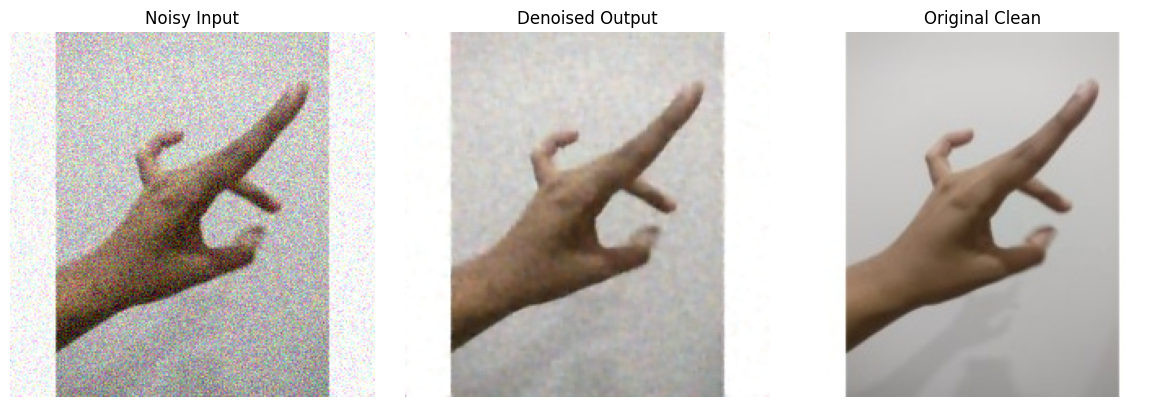

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor):
    # Converts tensor from [0, 1] (or normalized float) to [0, 255] for display
    tensor = tensor.cpu().detach().numpy()
    tensor = np.transpose(tensor, (1, 2, 0))  # CHW to HWC
    tensor = np.clip(tensor, 0, 1)  # in case of minor overflow
    return tensor

def visualize_results(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (noisy, clean) in enumerate(dataloader):
            noisy = noisy.to(device)
            outputs = model(noisy)

            for j in range(min(num_samples, noisy.size(0))):
                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(denormalize(noisy[j]))
                axes[0].set_title("Noisy Input")
                axes[1].imshow(denormalize(outputs[j]))
                axes[1].set_title("Denoised Output")
                axes[2].imshow(denormalize(clean[j]))
                axes[2].set_title("Original Clean")
                for ax in axes:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
            break  # only the first batch

# Call it like this:
visualize_results(model, test_loader, num_samples=5)
